In [ ]:
!pip install tqdm
!pip install spacy
!pip install fairseq
!pip install sklearn
!pip install tensorflow
!pip install sentencepiece

In [ ]:
!wget "http://2019.poleval.pl/task6/task_6-2.zip"
!unzip "./task_6-2.zip" -d "./data"
!rm "./task_6-2.zip"

In [ ]:
!wget "http://2019.poleval.pl/task6/task6_test.zip"
!unzip "./task6_test.zip" -d "./data"
!mv "./data/Task6/task 02/test_set_only_tags.txt" "./data/"
!mv "./data/Task6/task 02/test_set_only_text.txt" "./data/"
!rm -r "./task6_test.zip"
!rm -r "./data/Task6"

In [ ]:
!wget "https://github.com/sdadas/polish-roberta/releases/download/models-v2/roberta_base_fairseq.zip"
!unzip "./roberta_base_fairseq.zip" -d "./roberta"
!rm "./roberta_base_fairseq.zip"

In [184]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from spacy.lang.pl import Polish
from fairseq.models.roberta import RobertaModel, RobertaHubInterface
from fairseq import hub_utils

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

nlp = Polish()

RE_EMOJI = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

In [ ]:
model_path = "roberta"
loaded = hub_utils.from_pretrained(
    model_name_or_path=model_path,
    data_name_or_path=model_path,
    bpe="sentencepiece",
    sentencepiece_vocab="sentencepiece.bpe.model",
    load_checkpoint_heads=True,
    archive_map=RobertaModel.hub_models(),
    cpu=True
)
roberta = RobertaHubInterface(loaded['args'], loaded['task'], loaded['models'][0])
roberta.eval()

In [192]:
with open("./data/training_set_clean_only_text.txt", "r") as textFile:
    train_x = textFile.readlines()
with open("./data/training_set_clean_only_tags.txt", "r") as textFile:
    train_y = list(map(int,textFile.readlines()))

In [193]:
with open("./data/test_set_only_text.txt", "r") as textFile:
    test_x = textFile.readlines()
with open("./data/test_set_only_tags.txt", "r") as textFile:
    test_y = list(map(int,textFile.readlines()))

In [194]:
def preprocess_text(text):
    text = " ".join(text.split())
    doc = [tok for tok in nlp(text)]

    if str(doc[0]) == "RT": 
        doc.pop(0)

    while str(doc[0]) == "@anonymized_account":
        doc.pop(0)
    while str(doc[-1]) == "@anonymized_account":
        doc.pop()

    #doc = [t for t in doc if t.text not in string.punctuation]
    doc = [tok.text for tok in doc]
    doc = [RE_EMOJI.sub(r"", str_text) for str_text in doc]
    doc = [tok for tok in doc if len(tok) > 0]

    return doc

In [195]:
train_x = [preprocess_text(xi) for xi in train_x]
train_x = ["".join(xi) for xi in train_x]
train_x = [roberta.encode(xi) for xi in train_x]

In [196]:
test_x = [preprocess_text(xi) for xi in test_x]
test_x = ["".join(xi) for xi in test_x]
test_x = [roberta.encode(xi) for xi in test_x]

In [197]:
def extract_features(x):
    x_mean = []
    x_cls = []
    for xi in tqdm(x):
        features = roberta.extract_features(xi, return_all_hiddens=True)[-2].cpu().detach().numpy().squeeze()
        x_mean.append(features.mean(axis=0))
        x_cls.append(features[0])
    return x_mean,x_cls

In [198]:
train_x_mean,train_x_cls = extract_features(train_x)

100%|█████████████████████████████████████████████████████████████████████████████| 10041/10041 [15:07<00:00, 11.06it/s]


In [199]:
test_x_mean,test_x_cls = extract_features(test_x)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.77it/s]


In [214]:
train_x = train_x_mean
test_x = test_x_mean

In [215]:
def predict_stats(clf, test_x, test_y):
    predictions = clf.predict(test_x)
    stats(test_y, predictions)

In [216]:
def stats(test_y, predictions):
    micro_fscore = f1_score(test_y, predictions, average='micro')
    macro_fscore = f1_score(test_y, predictions, average='macro')
    print(micro_fscore)
    print(macro_fscore)

In [217]:
from sklearn import svm
clf = svm.LinearSVC(class_weight="balanced", dual=False)
clf.fit(train_x, train_y)
predict_stats(clf, test_x, test_y)

0.833
0.456413609800652


In [218]:
from sklearn import svm
clf = svm.SVC(class_weight="balanced")
clf.fit(train_x, train_y)
predict_stats(clf, test_x, test_y)

0.721
0.4335774885148307


In [219]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight="balanced")
clf.fit(train_x, train_y)
predict_stats(clf, test_x, test_y)

0.866
0.3093962129331904


In [220]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
clf.fit(train_x, train_y)
predict_stats(clf, test_x, test_y)

0.857
0.4134882475170963


In [399]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(512, input_shape=(768,), activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.35))
model.add(Dense(3, activation="softmax", kernel_initializer="he_normal"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [400]:
from tensorflow.keras.utils import to_categorical
train_y_ohe = to_categorical(train_y)
test_y_ohe = to_categorical(test_y)
train_x_np = np.array(train_x)
test_x_np = np.array(test_x)

In [401]:
epochs = 3
count = len(train_y)
class_weights = np.sum(train_y_ohe, axis=0)
class_weights = { i : (count - w) / count for i,w in enumerate(class_weights)}

In [402]:
feature = model.fit(
    train_x_np,
    train_y_ohe,
    epochs=epochs,
    batch_size=32,
    class_weight=class_weights,
    verbose=2,
    validation_data=(test_x_np, test_y_ohe)
)

Epoch 1/3
314/314 - 3s - loss: 0.1515 - accuracy: 0.7259 - val_loss: 0.7066 - val_accuracy: 0.6810 - 3s/epoch - 8ms/step
Epoch 2/3
314/314 - 2s - loss: 0.1345 - accuracy: 0.7568 - val_loss: 0.7099 - val_accuracy: 0.6900 - 2s/epoch - 6ms/step
Epoch 3/3
314/314 - 2s - loss: 0.1247 - accuracy: 0.7472 - val_loss: 0.6329 - val_accuracy: 0.7620 - 2s/epoch - 6ms/step


In [403]:
results = pd.DataFrame({
    "training_accuracy": feature.history["accuracy"],
    "training_loss": feature.history["loss"],
    "test_accuracy": feature.history["val_accuracy"],
    "test_loss": feature.history["val_loss"],
    "epoch": list(range(1, epochs + 1))
})

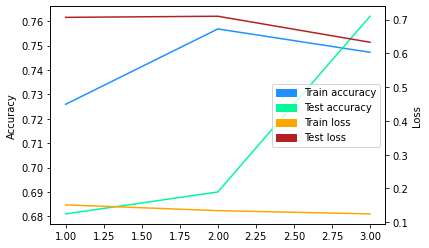

In [404]:
patches = [
    Patch(color='dodgerblue',label='Train accuracy'),
    Patch(color='mediumspringgreen',label='Test accuracy'),
    Patch(color='orange',label='Train loss'),
    Patch(color='firebrick',label='Test loss')
]

fig, ax1 = plt.subplots()

ax1.plot(results["epoch"],results["training_accuracy"],'dodgerblue')
ax1.plot(results["epoch"],results["test_accuracy"],'mediumspringgreen')
ax1.set_ylabel("Accuracy")

ax2 = ax1.twinx()
ax2.plot(results["epoch"],results["training_loss"],'orange')
ax2.plot(results["epoch"],results["test_loss"],'firebrick')
ax2.set_ylabel("Loss")

plt.legend(handles=patches)
plt.show()

In [405]:
predictions = np.argmax(model.predict(test_x_np), axis=1)
y_true = np.argmax(test_y_ohe, axis=1)
stats(y_true, predictions)

0.762
0.44433699633699636
